In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import glob
import re
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from plotnine import * 
import plotnine.options

In [2]:
sys.path.insert(1, '/secure/projects/tacco/')
import tacco as tc

In [3]:
from harmony import harmonize

In [4]:
#from sklearn.utils.sparsefuncs import inplace_column_scale, inplace_row_scale

In [5]:
sys.path.insert(1, '/secure/projects/HTAPP_MBC/src/')

In [6]:
from init_phase2 import * 

In [7]:
res_dir=baseDir+"/analysis/02_combined/"
os.makedirs(res_dir,exist_ok=True)

In [8]:
adata_all=sc.read_h5ad(out_dir+"/fresh_frozen_combined.h5ad")

In [9]:
def process(adata,resolution=0.4):    
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

    adata.raw = adata

    adata = adata[:, adata.var['highly_variable']]
    sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt'])

    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack',random_state=42)
    sc.pp.neighbors(adata,random_state=42)
    sc.tl.leiden(adata,resolution=resolution,random_state=42)
    sc.tl.umap(adata,random_state=42)
    return(adata)

In [10]:
def do_harmony(adata,resolution=0.4):
    #store old umap to prevent it from being overwritten
    adata.uns['orig_umap']=adata.uns['umap']
    adata.obsm['orig_X_umap']=adata.obsm['X_umap']
    Z = harmonize(adata.obsm['X_pca'], adata.obs, batch_key = ['batch'])

    adata.obsm['X_harmony'] = Z
    sc.pp.neighbors(adata,random_state=42,use_rep='X_harmony',key_added='harmony_nn')
    sc.tl.leiden(adata,random_state=42,resolution=resolution,neighbors_key='harmony_nn',key_added='harmony_leiden')
    sc.tl.leiden(adata,random_state=42,resolution=resolution,neighbors_key='neighbors',key_added='leiden')
    sc.tl.umap(adata,random_state=42,neighbors_key='harmony_nn')
    #move old umap back
    adata.uns['harmony_umap']=adata.uns['umap']
    adata.uns['umap']=adata.uns['orig_umap']
    adata.obsm['harmony_X_umap']=adata.obsm['X_umap']
    adata.obsm['X_umap']=adata.obsm['orig_X_umap']
    del(adata.uns['orig_umap'])
    del(adata.obsm['orig_X_umap'])
    return adata

In [11]:
pd.DataFrame(adata_all.obs.loc[:,['batch','name']].value_counts()).reset_index()['batch'].value_counts()

sn    37
sc    30
Name: batch, dtype: int64

In [12]:
sel_obs=['batch', 'cell_id', 'name', 'condition', 'replicate', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito','pct_counts_mt','cell_type']

In [21]:
#only Macrophages
adata_sel=anndata.AnnData(X=adata_all[adata_all.obs.cell_type=="Macrophage"].obsm['counts'],obs=adata_all[adata_all.obs.cell_type=="Macrophage"].obs[sel_obs],var=pd.DataFrame(index=adata_all[adata_all.obs.cell_type=="Macrophage"].raw.var.index))

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [22]:
adata_sel=process(adata_sel)

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [23]:
adata_sel=do_harmony(adata_sel)

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


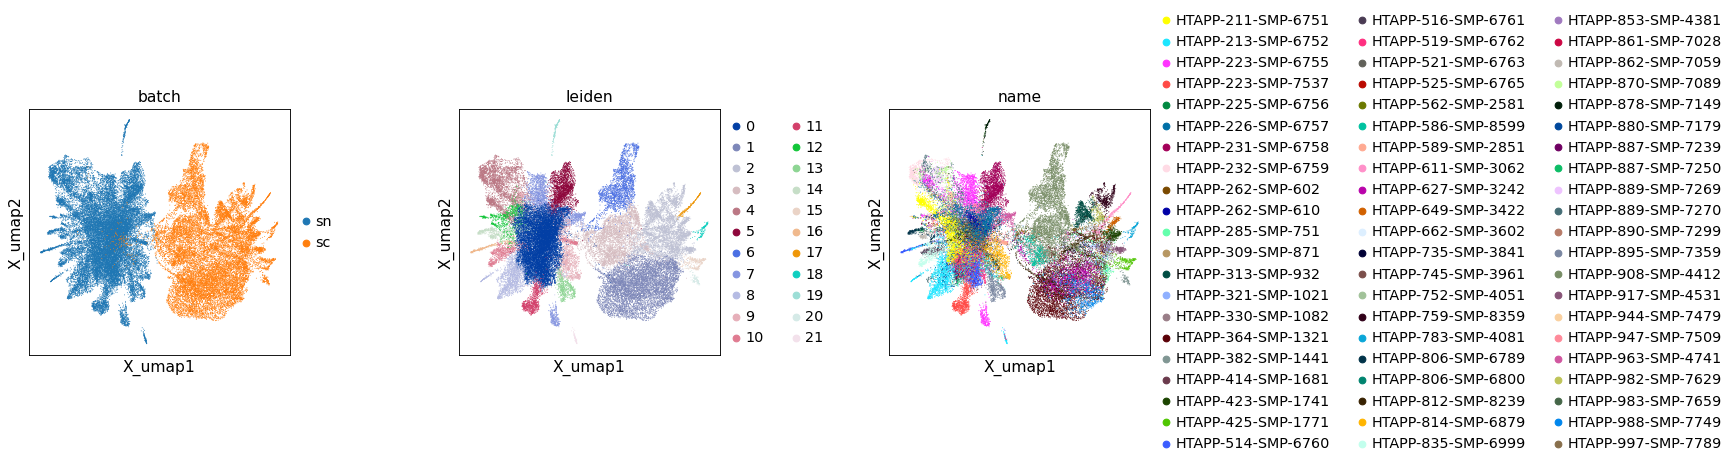

In [24]:
fig=sc.pl.embedding(adata_sel,basis='X_umap', color=['batch','leiden','name'],return_fig=True,wspace=0.5)
fig.savefig(res_dir+'/UMAP_pre_harmony_MP.pdf',bbox_inches='tight')

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


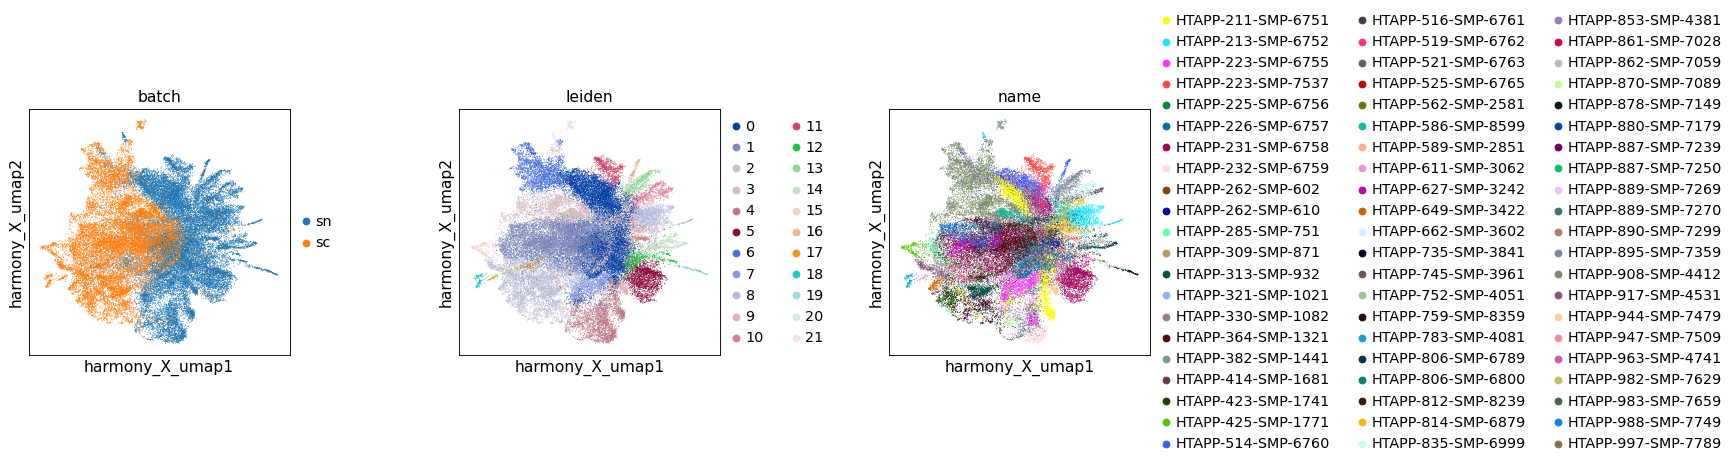

In [25]:
fig=sc.pl.embedding(adata_sel,basis='harmony_X_umap', color=['batch','leiden','name'],return_fig=True,wspace=0.5)
fig.savefig(res_dir+'/UMAP_post_harmony_MP.pdf',bbox_inches='tight')

In [26]:
#only T
adata_sel=anndata.AnnData(X=adata_all[adata_all.obs.cell_type=="T"].obsm['counts'],obs=adata_all[adata_all.obs.cell_type=="T"].obs[sel_obs],var=pd.DataFrame(index=adata_all[adata_all.obs.cell_type=="T"].raw.var.index))

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [27]:
adata_sel=process(adata_sel)

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [28]:
adata_sel=do_harmony(adata_sel)

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


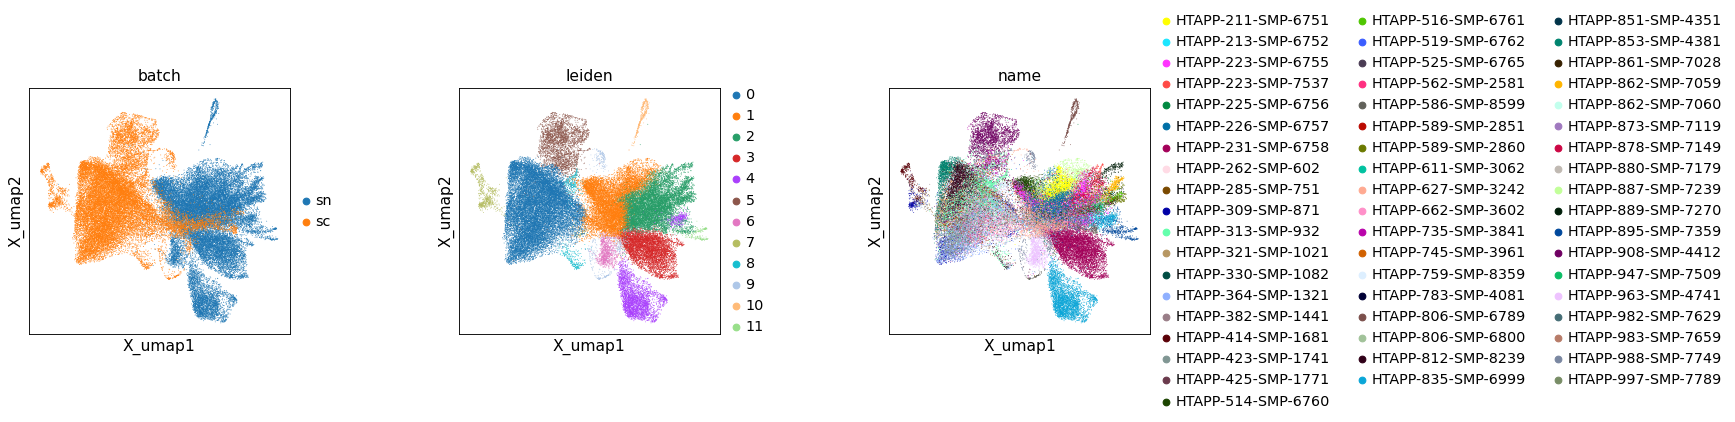

In [29]:
fig=sc.pl.embedding(adata_sel,basis='X_umap', color=['batch','leiden','name'],return_fig=True,wspace=0.5)
fig.savefig(res_dir+'/UMAP_pre_harmony_T.pdf',bbox_inches='tight')

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


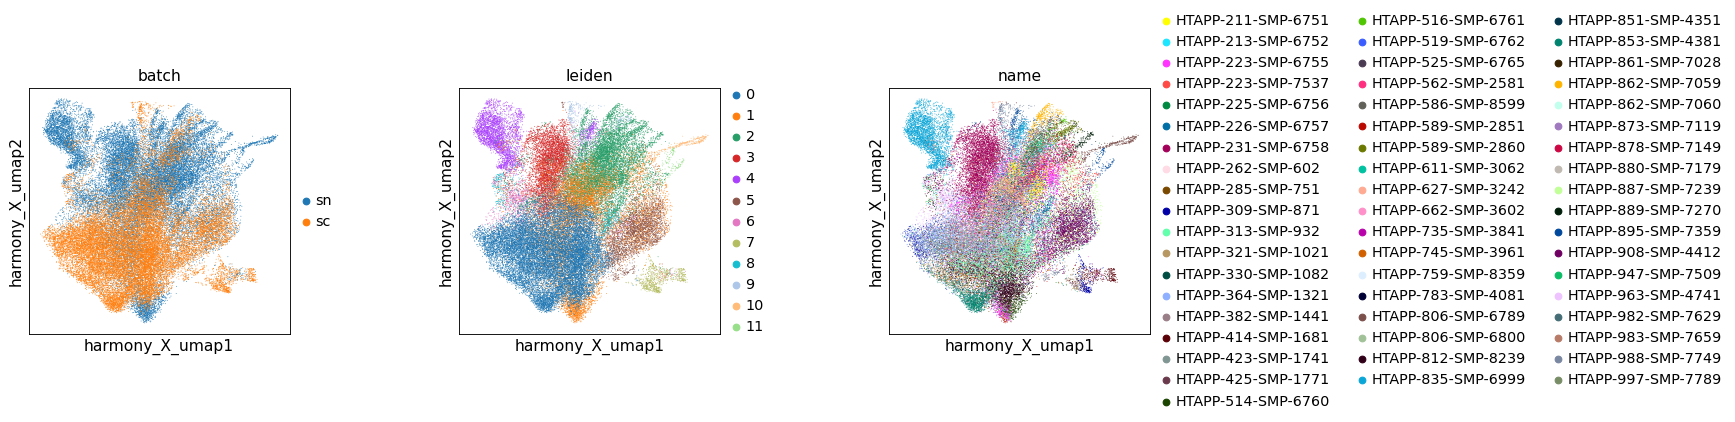

In [30]:
fig=sc.pl.embedding(adata_sel,basis='harmony_X_umap', color=['batch','leiden','name'],return_fig=True,wspace=0.5)
fig.savefig(res_dir+'/UMAP_post_harmony_T.pdf',bbox_inches='tight')

In [31]:
#only Fibroblast
adata_sel=anndata.AnnData(X=adata_all[adata_all.obs.cell_type=="Fibroblast"].obsm['counts'],obs=adata_all[adata_all.obs.cell_type=="Fibroblast"].obs[sel_obs],var=pd.DataFrame(index=adata_all[adata_all.obs.cell_type=="Fibroblast"].raw.var.index))

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [32]:
adata_sel=process(adata_sel)

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [33]:
adata_sel=do_harmony(adata_sel)

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


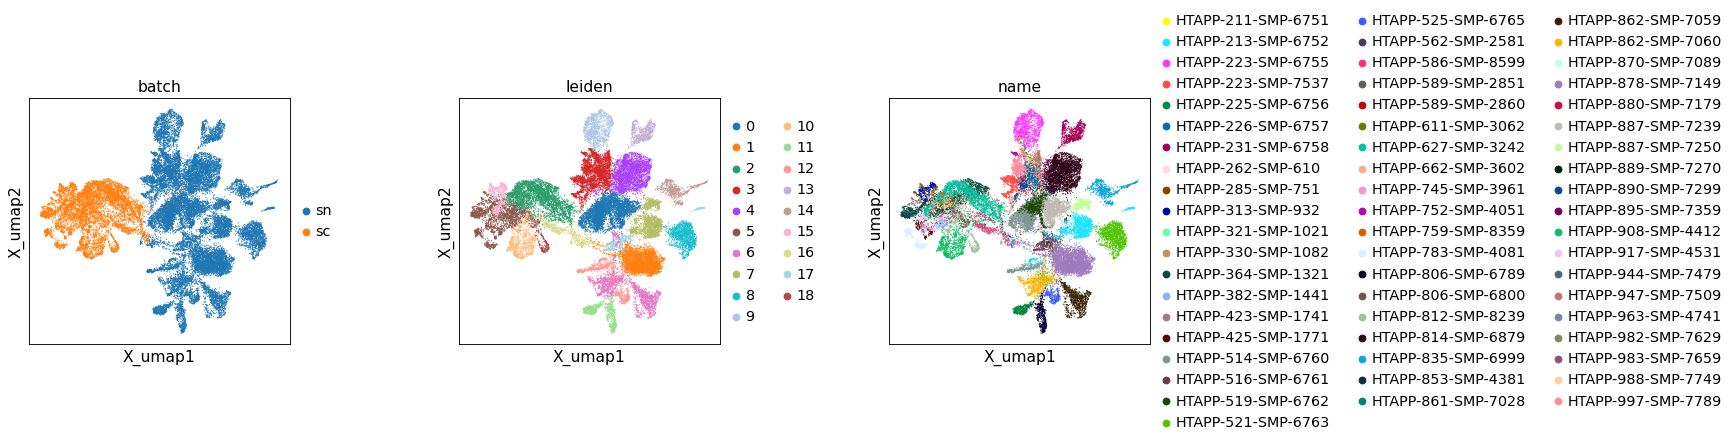

In [34]:
fig=sc.pl.embedding(adata_sel,basis='X_umap', color=['batch','leiden','name'],return_fig=True,wspace=0.5)
fig.savefig(res_dir+'/UMAP_pre_harmony_Fib.pdf',bbox_inches='tight')

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


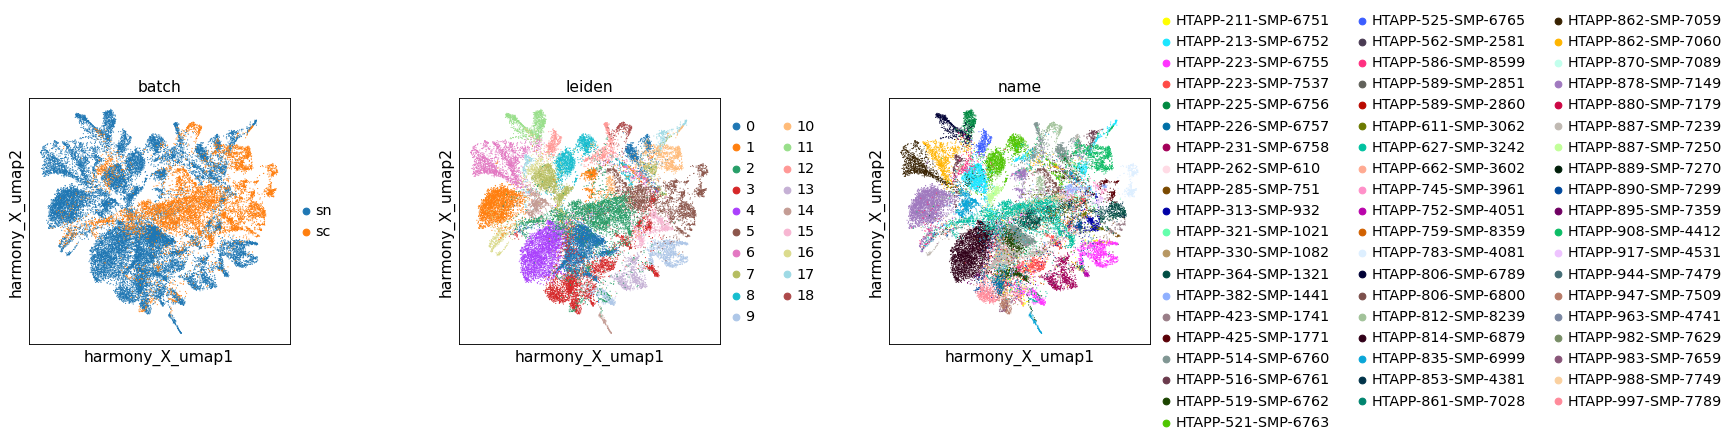

In [35]:
fig=sc.pl.embedding(adata_sel,basis='harmony_X_umap', color=['batch','leiden','name'],return_fig=True,wspace=0.5)
fig.savefig(res_dir+'/UMAP_post_harmony_Fib.pdf',bbox_inches='tight')

In [47]:
#only Malignant
adata_sel=anndata.AnnData(X=adata_all[adata_all.obs.cell_type.isin(['MBC','MBC_neuronal','MBC_stem-like'])].obsm['counts'],obs=adata_all[adata_all.obs.cell_type.isin(['MBC','MBC_neuronal','MBC_stem-like'])].obs[sel_obs],var=pd.DataFrame(index=adata_all[adata_all.obs.cell_type.isin(['MBC','MBC_neuronal','MBC_stem-like'])].raw.var.index))

In [48]:
adata_sel=process(adata_sel)

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [49]:
adata_sel=do_harmony(adata_sel)

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


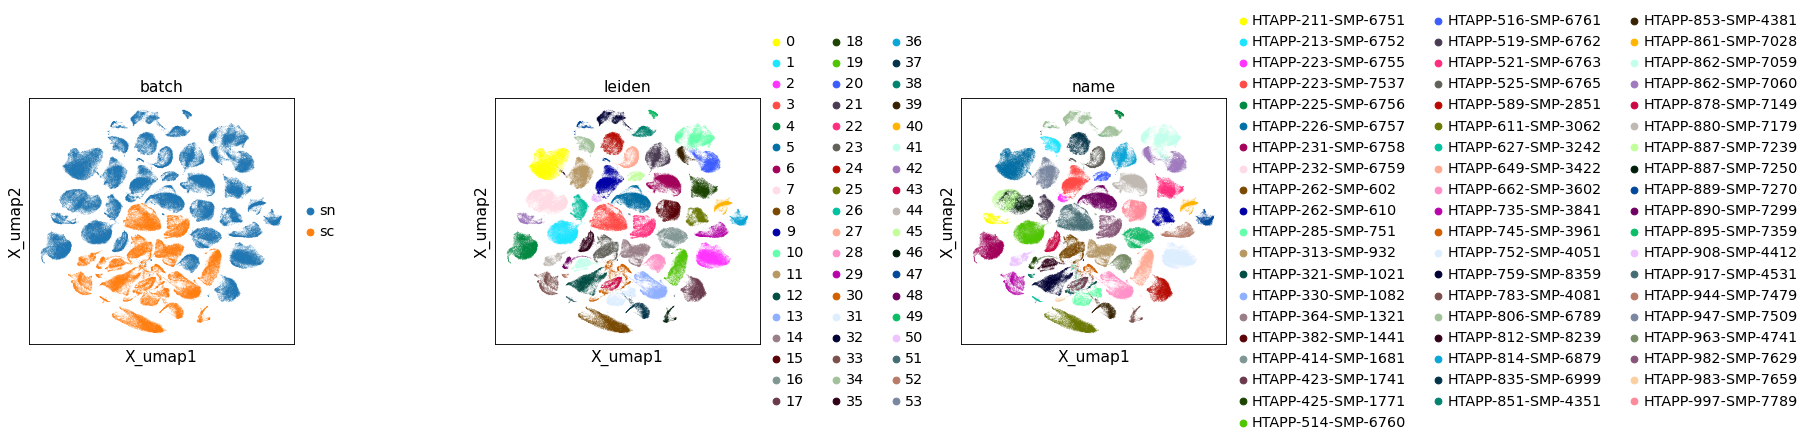

In [50]:
fig=sc.pl.embedding(adata_sel,basis='X_umap', color=['batch','leiden','name'],return_fig=True,wspace=0.6)
fig.savefig(res_dir+'/UMAP_pre_harmony_Mal.pdf',bbox_inches='tight')

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


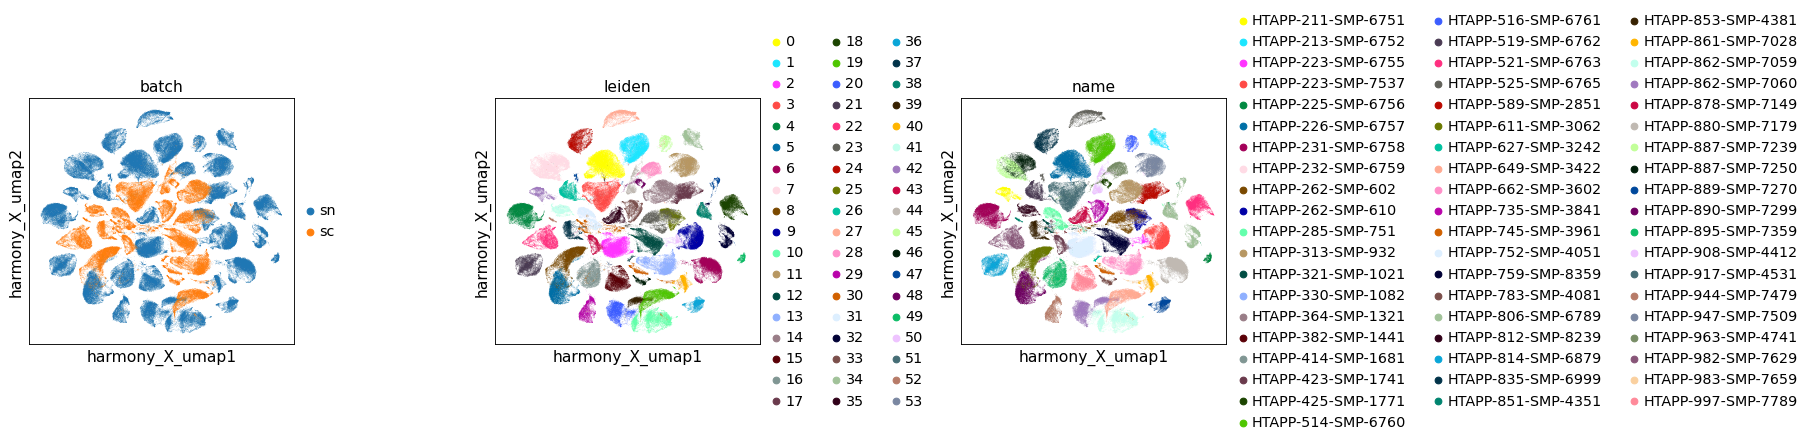

In [51]:
fig=sc.pl.embedding(adata_sel,basis='harmony_X_umap', color=['batch','leiden','name'],return_fig=True,wspace=0.6)
fig.savefig(res_dir+'/UMAP_post_harmony_Mal.pdf',bbox_inches='tight')

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


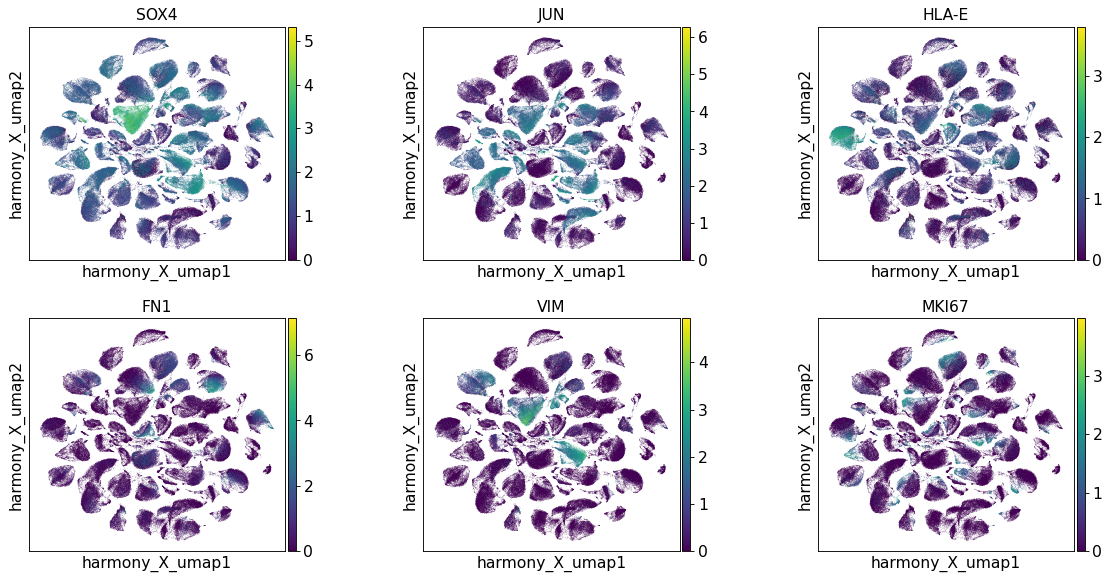

In [62]:
fig=sc.pl.embedding(adata_sel,basis='harmony_X_umap', color=['SOX4','JUN','HLA-E','FN1','VIM','MKI67'],ncols=3,use_raw=True,return_fig=True,wspace=0.4)
fig.savefig(res_dir+'/UMAP_post_harmony_Mal_GOI.pdf',bbox_inches='tight')

In [13]:
#All cells
adata_sel=anndata.AnnData(X=adata_all.obsm['counts'],obs=adata_all.obs[sel_obs],var=pd.DataFrame(index=adata_all.raw.var.index))

In [14]:
adata_sel=process(adata_sel)

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [15]:
adata_sel=do_harmony(adata_sel)

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


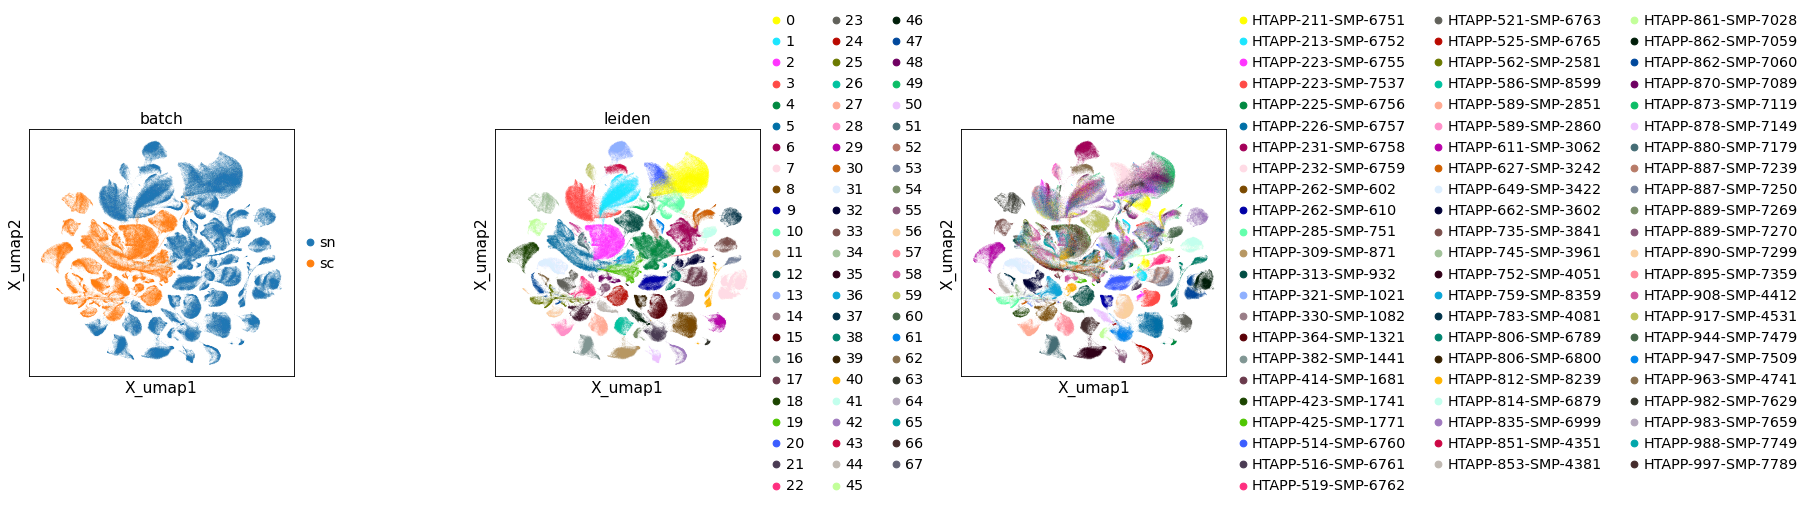

In [16]:
fig=sc.pl.embedding(adata_sel,basis='X_umap', color=['batch','leiden','name'],return_fig=True,wspace=0.6)
fig.savefig(res_dir+'/UMAP_pre_harmony_all.pdf',bbox_inches='tight')

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


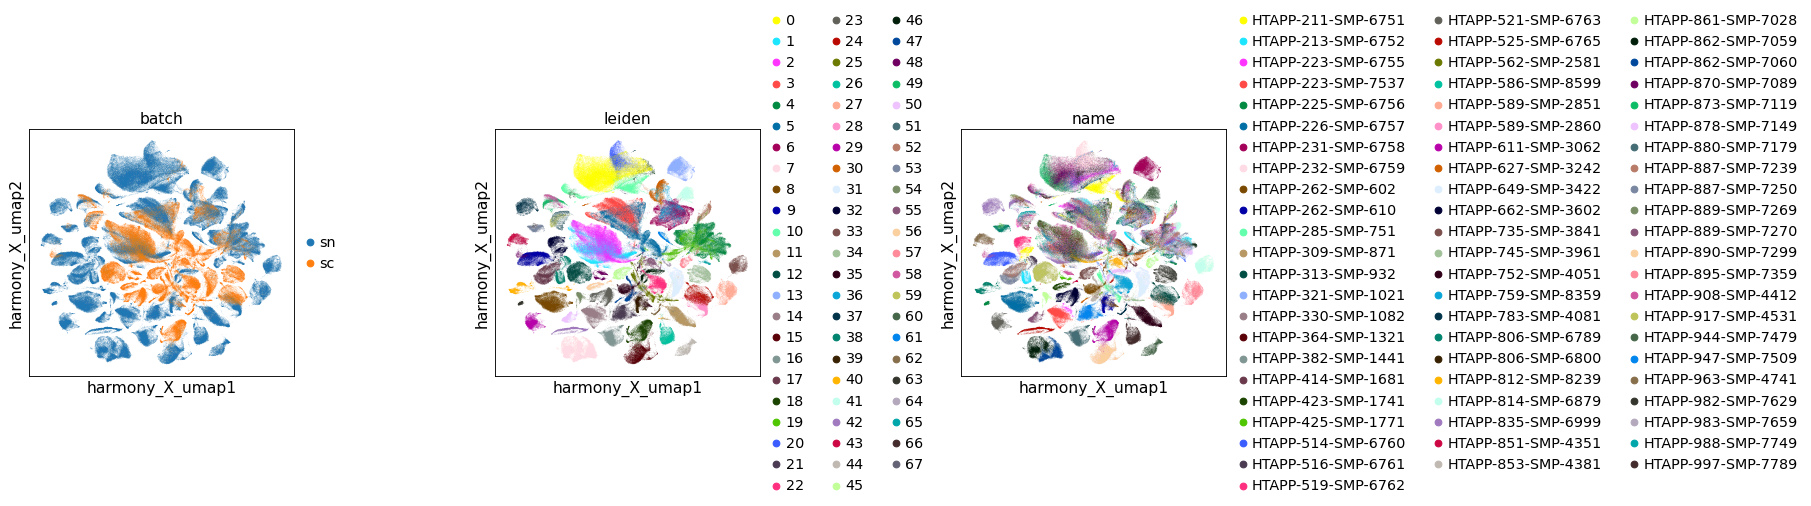

In [17]:
fig=sc.pl.embedding(adata_sel,basis='harmony_X_umap', color=['batch','leiden','name'],return_fig=True,wspace=0.6)
fig.savefig(res_dir+'/UMAP_post_harmony_all.pdf',bbox_inches='tight')

In [18]:
adata_sel.obs['cell_type']=pd.Categorical(adata_sel.obs['cell_type'], categories=colors.index)

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


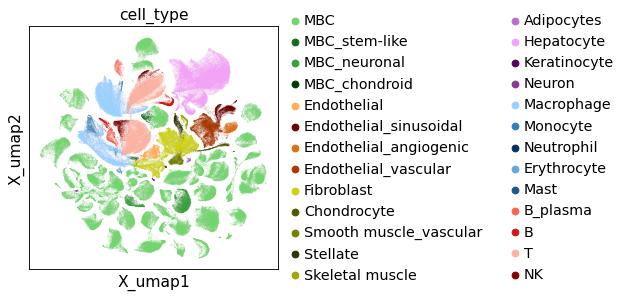

In [19]:
fig = sc.pl.embedding(adata_sel,basis='X_umap', color=['cell_type'],palette=colors.values.tolist(),return_fig=True);
fig.savefig(res_dir+'/UMAP_pre_harmony_all_ct.pdf',bbox_inches='tight')

/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


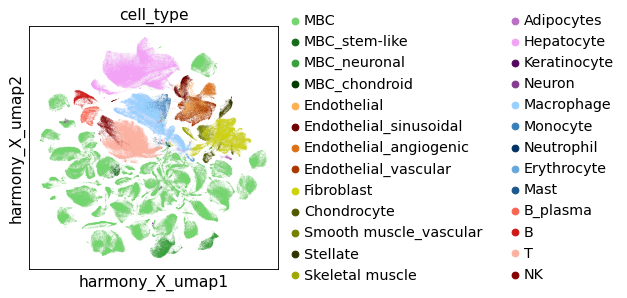

In [20]:
fig = sc.pl.embedding(adata_sel,basis='harmony_X_umap', color=['cell_type'],palette=colors.values.tolist(),return_fig=True);
fig.savefig(res_dir+'/UMAP_post_harmony_all_ct.pdf',bbox_inches='tight')